## General Info

This notebook contains a record linkage process using different kinds of preprocessing, blockings and classifier approaches for the __FEII 2016 challenge__. <br>
All information about the challenge are available at this link: https://ir.nist.gov/feiii/2016-challenge.html

All datasets provided contains information about __financial entities__ from different sources.

This challenge also provides us __partial ground truths__ to evaluate our matchings. 

### Goals

The goals of this challenge are: <br>

- identify matching records between __FFIEC and LEI__ datasets (FFIEC ⭢ LEI)
- identify matching records between __FFIEC and SEC__ datasets (FFIEC ⭢ SEC)

### Tools and workflow

Our record linkage process makes use of the __Python Record Linkage Toolkit__ (Documentation: https://recordlinkage.readthedocs.io/en/latest/about.html). <br> The package contains indexing (or blocking) methods, functions to compare records and machine learning classifiers to classify matching and not matching records. We also use standalone machine learning classifiers for a supervised learning approach. <br>

The workflow adopted for this project is the following:

<img src="./report/images/workflow.png">

## Imports

In [1]:
import recordlinkage
from recordlinkage.preprocessing import clean
from recordlinkage.compare import Exact, String, VariableA, VariableB
import pandas as pd
import nltk
from cleanco import cleanco
from collections import Counter
import re
import time
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier

## Read Datasets

In this section we read all datasets needed:

- FFIEC
- LEI
- SEC
- ground truths

### Read FFIEC

In [2]:
df1 = pd.read_csv('./data/FFIEC.csv')

In [3]:
df1.head(5)

,IDRSSD,FDIC Certificate Number,OCC Charter Number,OTS Docket Number,Primary ABA Routing Number,Financial Institution Name,Financial Institution Name Cleaned,Financial Institution Address,Financial Institution City,Financial Institution State,Financial Institution Zip Code,Financial Institution Zip Code 5,Financial Institution Filing Type,Last Date/Time Submission Updated On
0,37,10057,0,16553,61107146,BANK OF HANCOCK COUNTY,BANK OF HANCOCK COUNTY,12855 BROAD STREET,SPARTA,GA,31087,31087,41,2014-10-24T16:36:37
1,242,3850,0,0,81220537,FIRST COMMUNITY BANK XENIA-FLORA,FIRST COMMUNITY BANK XENIA-FLORA,260 FRONT STREET,XENIA,IL,62899,62899,41,2014-10-28T12:58:37
2,279,28868,0,2523,311972526,"MINEOLA COMMUNITY BANK, SSB","MINEOLA COMMUNITY BANK, SSB",215 W BROAD,MINEOLA,TX,75773,75773,41,2014-10-28T14:04:07
3,354,14083,0,0,101107475,BISON STATE BANK,BISON STATE BANK,223 MAIN STREET,BISON,KS,67520,67520,41,2014-10-23T13:12:50
4,457,10202,0,0,91208332,LOWRY STATE BANK,LOWRY STATE BANK,400 FLORENCE AVE.,LOWRY,MN,56349,56349,41,2014-10-14T11:52:12


### Read LEI

In [4]:
df2 = pd.read_csv('./data/LEI.csv', engine='python')

In [5]:
df2.head(5)

,LOU,LOU_ID,LEI,LegalName,LegalNameCleaned,AssociatedLEI,AssociatedEntityName,LegalAddress_Line_Cleaned,LegalAddress_Line_Combined,LegalAddress_Line1,...,BusinessRegisterEntityID,EntityStatus,InitialRegistrationDate,RegistrationStatus,LastUpdateDate,EntityExpirationDate,EntityExpirationReason,NextRenewalDate,SuccessorLEI,LegalForm
0,5493,GMEI,549300D5GJV4HUX52B25,Black Diamond BGWB14 Inc.,Black Diamond BGWB14 Inc.,NaN,NaN,Corporation Trust Center 1209 Orange Street,C/O The Corporation Trust Company Corporation ...,C/O The Corporation Trust Company,...,NaN,ACTIVE,2/22/14,ISSUED,1/24/15,NaN,NaN,1/13/16,NaN,INCORPORATED
1,2138,IEI,213800AEWHVA48PG1673,INFIGEN ENERGY US PARTNERSHIP,INFIGEN ENERGY US PARTNERSHIP,NaN,NaN,CORPORATION SERVICE COMPANY 2711 CENTERVILLE R...,CORPORATION SERVICE COMPANY 2711 CENTERVILLE R...,CORPORATION SERVICE COMPANY,...,4350761,ACTIVE,12/22/14,ISSUED,12/22/14,NaN,NaN,12/22/15,NaN,PARTNERSHIP
2,5493,GMEI,5493001BP0K5C4YI1257,"Nextgen Finance, LLC","Nextgen Finance, LLC",NaN,NaN,2711 Centerville Road Suite 400,C/O Corporation Service Company 2711 Centervil...,C/O Corporation Service Company,...,NaN,ACTIVE,5/17/14,ISSUED,4/2/15,NaN,NaN,3/28/16,NaN,LIMITED LIABILITY COMPANY
3,5493,GMEI,549300O17WX08AA1RA13,pControl North America Inc.,pControl North America Inc.,NaN,NaN,615 South DuPont Highway,"C/O National Corporate Research, Ltd. 615 Sout...","C/O National Corporate Research, Ltd.",...,NaN,ACTIVE,5/24/14,ISSUED,4/18/15,NaN,NaN,4/16/16,NaN,INCORPORATED
4,5493,GMEI,549300S6SBBS482XV369,"RYCO Hydraulics, Inc.","RYCO Hydraulics, Inc.",NaN,NaN,615 South DuPont Highway Suite 100,C/O Nelson C Metzler Jr 615 South DuPont Highw...,C/O Nelson C Metzler Jr,...,NaN,ACTIVE,9/6/14,ISSUED,9/6/14,NaN,NaN,9/4/15,NaN,INCORPORATED


### Read SEC

In [6]:
df3 = pd.read_csv('./data/SEC.csv', engine='python')

In [7]:
df3.head(5)

,CIK,IRS_NUMBER,CONFORMED_NAME,MinOfFILING_DATE,FORMER_CONFORMED_NAME,FORMER_NAME_CHANGED,ASSIGNED_SIC,I_COUNTRY,I_STPR,B_STREET,...,B_POSTAL,B_COUNTRY,B_PHONE,M_STREET,M_STREET1,M_STREET2,M_CITY,M_STPR,M_POSTAL,M_COUNTRY
0,20,221759452.0,K TRON INTERNATIONAL INC,20080722,NaN,NaN,3823.0,US,NJ,ROUTE 55 & 553 BOX 888,...,08071-0888,US,8562563318,ROUTE 55 & 553 P O BOX 888,ROUTE 55 & 553,P O BOX 888,PITMAN,NJ,08071-0888,US
1,1750,362334820.0,AAR CORP,20080605,ALLEN AIRCRAFT RADIO INC,19700204.0,3720.0,US,DE,1100 N WOOD DALE RD,...,60191,US,6302272000,1100 N WOOD DALE RD,1100 N WOOD DALE RD,NaN,WOOD DALE,IL,60191,US
2,1800,360698440.0,ABBOTT LABORATORIES,20080703,NaN,NaN,2834.0,US,IL,100 ABBOTT PARK ROAD D-322 AP6D,...,60064-3500,US,8479376100,,NaN,NaN,NaN,NaN,NaN,NaN
3,1841,132833083.0,ABEL/NOSER CORPORATION,20090317,ABEL NOSER CORP ...,20000101.0,NaN,US,NY,ONE BATTERY PARK PLAZA 6TH FLOOR,...,10004,US,646-432-4170,ONE BATTERY PARK PLAZA 6TH FLOOR,ONE BATTERY PARK PLAZA,6TH FLOOR,NEW YORK,NY,10004,US
4,1853,826008492.0,"MOTIVNATION, INC.",20080612,ABERDEEN IDAHO MINING CO,20000101.0,3711.0,NaN,NaN,"18101 VON KARMAN AVE., SUITE 330",...,92612,US,949-888-8060,"18101 VON KARMAN AVE., SUITE 330","18101 VON KARMAN AVE., SUITE 330",NaN,IRVINE,CA,92612,US


### Read ground truths

#### FFIEC ⭢ LEI

In [8]:
FFIEC_LEI_gt = pd.read_csv('./data/FFIEC-LEI-GroundTruth.csv', sep='\t')
FFIEC_LEI_gt = FFIEC_LEI_gt.set_index(['FFIEC_ID','LEI_ID'])

In [9]:
FFIEC_LEI_gt.head(5)

,,TYPE
FFIEC_ID,LEI_ID,
68756,549300465MKS092D5K02,TP
63069,593C3GZG957YOJPS2Z63,TP
3560783,549300KIB2BK64XF5262,TP
1356768,5493008ZK5SW6NTWB533,TP
3470985,549300DCFF8W6ZAEKH70,TP


#### FFIEC ⭢ SEC

In [10]:
FFIEC_SEC_gt = pd.read_csv('./data/FFIEC-SEC-GroundTruth.csv', sep='\t')
FFIEC_SEC_gt = FFIEC_SEC_gt.set_index(['FFIEC_ID','SEC_ID'])

In [11]:
FFIEC_SEC_gt.head(5)

,,TYPE
FFIEC_ID,SEC_ID,
436711,1430521,TP
618740,1594492,TP
63069,275216,TP
3348888,1552682,TP
895710,1520684,TP


## Preprocessing

Here we define all the function needed for the preprocessing phase: cleaning data, normalization and other operations.

By analyzing our data we found:

- inconsistent addresses information. <br> e.g: SEC contains, in the same address attribute, information about the P.O. BOX addresses which is not present in other datasets. <br> e.g: normalization of words for example st ⭢ street


- zipcodes length not uniform.


- There is implicit semantic knowledge included in a name, e.g., a name may contain “National Association” or “State Bank of” in its name. This complicates matching based on a similarity score.


- Stopwords and punctuation differ between the same abbreviations or words.

### Utils functions

In [12]:
def normalizeAddress(sentence):
    # normalize road types
    for key in road_types:
        sentence = re.sub(r"\s*\b"+re.escape(key)+r"\b\s*", ' '+road_types[key]+' ', sentence)
    # normalize road orientations
    for key in road_orientations:
        sentence = re.sub(r"\s*\b"+re.escape(key)+r"\b\s*", ' '+road_orientations[key]+' ', sentence)
    sentence = re.sub(r"\s*\bpo box \d{0,}\b\s*",' ', sentence)
    sentence = re.sub(r"\s*\bbox \d{0,}\b\s*",' ', sentence)
    sentence = sentence.strip()
    return sentence

def normalizeZipCode(zip_code):
    if zip_code == 'NaN':
        return zip_code
    # takes first "5" digits
    zip_code = zip_code.split('-')[0]

    # adding initial zeros to partial zip codes
    zeros = 5 - len(zip_code)
    while zeros > 0:
        zip_code = '0' + zip_code
        zeros -= 1
    return zip_code
        

def normalizeNameModifier(sentence):
    modifier = None
    for key in name_modifiers:
        if re.search(r"\b"+re.escape(key)+r"\b", sentence):
            modifier = name_modifiers[key]
            sentence = re.sub(r"\s*\b"+re.escape(key)+r"\b\s*",' ', sentence)

    for key in name_modifiers:
        if re.search(r"\b"+re.escape(name_modifiers[key])+r"\b", sentence):
            modifier = name_modifiers[key]
            sentence = re.sub(r"\s*\b"+re.escape(name_modifiers[key])+r"\b\s*",' ', sentence)
    sentence = re.sub('\s+',' ',sentence).strip()
    return sentence, modifier

def removeStopWords(sentence):
    tokens = nltk.tokenize.word_tokenize(sentence)
    tokens = [word for word in tokens if word not in stop_words]
    ret = ' '.join(tokens)
    return ret

def flatten(listoflists):
    return [item for list in listoflists for item in list]

def mostCommonWords(names):
    tokens = names.apply(nltk.tokenize.word_tokenize)
    tokens = tokens.apply(lambda x: [word for word in x if word not in stop_words])
    ugs = Counter(flatten(tokens.apply(lambda x : list(nltk.ngrams(x, 1)))))
    bgs = Counter(flatten(tokens.apply(lambda x : list(nltk.ngrams(x, 2)))))
    tgs = Counter(flatten(tokens.apply(lambda x : list(nltk.ngrams(x, 3)))))
    return ugs, bgs, tgs

# stop words list
stop_words = nltk.corpus.stopwords.words('english')

# name modifiers dictionary
name_modifiers = {'corp': 'corporation', 'co': 'company', 'fsb': 'federal savings bank',
                  'na': 'national association', 'inc': 'incorporated', 'ta': 'trust association'}

# orientation dictionary
road_orientations = {'north': 'n', 'south': 's', 'east': 'e', 'west': 'w', 
                'northeast': 'ne', 'northwest': 'nw', 'southeast': 'se', 'southwest': 'sw'}

# road types dictionary
road_types = {'street': 'st', 'road': 'rd', 'avenue': 'ave', 'square': 'sq',
              'lane': 'la', 'suite': 'su', 'plaza': 'pl' }

### Cleaning functions

Here we defined cleaning functions which use the previously defined preprocessing functions for an easier utilization later on.

#### FFIEC

In [13]:
# verify IDs uniqueness
print('FFIEC:')
print(df1['IDRSSD'].value_counts())
print('\nNo removes needed...')

FFIEC:
399357     1
17978      1
448040     1
640554     1
3482166    1
          ..
375650     1
734051     1
28406      1
533124     1
3045383    1
Name: IDRSSD, Length: 6652, dtype: int64

No removes needed...


In [14]:
def preprocessFFIEC(df, name=True, stopwords=True, modifier=True, address=True):
    # filter out unwanted columns from dataframe
    df = pd.DataFrame(df[['IDRSSD', 'Financial Institution Name Cleaned', \
                          'Financial Institution Address', 'Financial Institution City', \
                          'Financial Institution State', 'Financial Institution Zip Code 5']])
    # set id index 
    df = df.set_index('IDRSSD')
    # clean Name
    if name:
        df['Financial Institution Name Cleaned'] = df['Financial Institution Name Cleaned'].str.replace('&', ' and ')
        df['Financial Institution Name Cleaned'] = clean(df['Financial Institution Name Cleaned'])
        # remove stopwords
        if stopwords:
            df['Financial Institution Name Cleaned'] = df['Financial Institution Name Cleaned'].apply(removeStopWords)
        # remove name modifier
        if modifier:
            df[['Financial Institution Name Cleaned', 'MODIFIER']] = df.apply(lambda x: pd.Series(normalizeNameModifier(x['Financial Institution Name Cleaned'])), axis=1)
    # clean address
    if address:
        df['Financial Institution Address'] = clean(df['Financial Institution Address']).apply(normalizeAddress)
    # clean city
    df['Financial Institution City'] = clean(df['Financial Institution City'])
    # clean postal code
    df['Financial Institution Zip Code 5'] = df['Financial Institution Zip Code 5'].astype(str).apply(normalizeZipCode)
    return df

#### LEI

In [15]:
print('LEI:')
print(df2['LEI'].value_counts())
print('\n Need to remove record with LEI =', '9.598E+19' )

LEI:
9.598E+19               9
549300DT8SH0CF6BTT37    1
5493007KJQJ3YKET6L74    1
6M5VVHP54K5BPR2GI852    1
549300CW9L0BVQY20W81    1
                       ..
54930005O0Z1ZPIEB793    1
549300MG78OMJG7UHF07    1
549300EZHHTTDNQF5G02    1
549300TS75MG79QT5F80    1
549300SBN40YH05GIW70    1
Name: LEI, Length: 53950, dtype: int64

 Need to remove record with LEI = 9.598E+19


In [16]:
def preprocessLEI(df, name=True, stopwords=True, modifier=True, address=True):
    # filter out unwanted columns from dataframe
    df = pd.DataFrame(df[['LEI', 'LegalNameCleaned', 'LegalAddress_Line_Cleaned', \
                        'LegalAddress_City', 'LegalAddress_Region_2', 'LegalAddress_Country', 'LegalAddress_PostalCode_5']])
    
    # set id as index
    df = df.set_index('LEI')
    
    # remove invalid records
    df = pd.DataFrame(df.drop('9.598E+19'))
    
    # clean Name
    if name:
        df['LegalNameCleaned'] = df['LegalNameCleaned'].str.replace('&', ' and ')
        df['LegalNameCleaned'] = clean(df['LegalNameCleaned'])
        # remove stopwords
        if stopwords:
            df['LegalNameCleaned'] = df['LegalNameCleaned'].apply(removeStopWords) 
        # remove name modifier
        if modifier:
            df[['LegalNameCleaned', 'MODIFIER']] = df.apply(lambda x: pd.Series(normalizeNameModifier(x['LegalNameCleaned'])), axis=1)
    # clean address
    if address:
        df['LegalAddress_Line_Cleaned'] = clean(df['LegalAddress_Line_Cleaned']).apply(normalizeAddress)
    # clean city
    df['LegalAddress_City'] = clean(df['LegalAddress_City'])
    # clean postal code
    df['LegalAddress_PostalCode_5'] = df['LegalAddress_PostalCode_5'].apply(lambda x : str(int(x) if str(x) != 'nan' else x))\
                                                                     .apply(normalizeZipCode)
    return df

#### SEC

In [17]:
# verify IDs uniqueness
print('SEC:')
print(df3['CIK'].value_counts())
print('\nNo removes needed...')

SEC:
790526     1
1596732    1
1501174    1
1133076    1
1482745    1
          ..
1625266    1
215740     1
1524413    1
744126     1
1312769    1
Name: CIK, Length: 129312, dtype: int64

No removes needed...


In [18]:
def preprocessSEC(df, name=True, stopwords=True, modifier=True, address=True):
    # filter out unwanted columns from dataframe
    df = pd.DataFrame(df[['CIK', 'CONFORMED_NAME', 'B_STREET', \
                        'B_CITY', 'B_STPR', 'B_POSTAL']])
    # set id as index
    df = df.set_index('CIK')
    # clean Name
    if name:
        df['CONFORMED_NAME'] = df['CONFORMED_NAME'].str.replace('&', ' and ')
        df['CONFORMED_NAME'] = clean(df['CONFORMED_NAME'])
        # remove stopwords
        if stopwords:
            df['CONFORMED_NAME'] = df['CONFORMED_NAME'].apply(removeStopWords)
        # remove name modifier
        if modifier:
            df[['CONFORMED_NAME', 'MODIFIER']] = df.apply(lambda x: pd.Series(normalizeNameModifier(x['CONFORMED_NAME'])), axis=1)
    # clean address
    if address:
        # TODO: define clean address
        df['B_STREET'] = clean(df['B_STREET']).apply(normalizeAddress)
    # clean city
    df['B_CITY'] = clean(df['B_CITY'])
    # clean postal code
    df['B_POSTAL'] = df['B_POSTAL'].astype(str).apply(normalizeZipCode)
    return df

#### preprocessAll

In [19]:
def preprocessAll(df_FFIEC, df_LEI, df_SEC, name=True, stopwords=True, modifier=True, address=True):
    df_FFIEC = preprocessFFIEC(df_FFIEC, name, stopwords, modifier, address)
    df_LEI = preprocessLEI(df_LEI, name, stopwords, modifier, address)
    df_SEC = preprocessSEC(df_SEC, name, stopwords, modifier, address)
    return df_FFIEC, df_LEI, df_SEC

## Blocking

Here we define functions which make use of the __Python Record Linkage Toolkit__ to implement different blocking strategies. A blocking strategy is used to create and limit the number of record pairs which needs to be compared later on to indentify the matching ones. We considered:

- Full Indexing: no blocking strategy is applied. A full index is an index with all possible combinations of record pairs. Returns the cartesian products of the records from each dataset. This is usually not the best choice in terms of performance.


<img src="./report/images/full_indexing.png">

- Exact Blocking: returns all record pairs that agree on the given variable(s).

- Sorted Neighbourhood Blocking: sorts records based on a sorting key and moves a window of size _n_ over the sorted records. Records within the window are paired with each other to form the candidate record pair list. The Sorted Neighbourhood Blocking method is a great method when there is relatively large amount of spelling mistakes.

### Functions definitions

In [20]:
# full indexing, computationally expensive
def fullIndexing(df_A, df_B):
    start_time = time.time()
    indexer = recordlinkage.Index()
    indexer.full()
    candidate_links = indexer.index(df_A, df_B)
    print("Execution time: %s seconds " % (time.time() - start_time))
    return candidate_links

# exact blocking
def exactBlocking(df_A, df_B, column_A, column_B):
    start_time = time.time()
    indexer = recordlinkage.Index()
    indexer.block(left_on=[column_A], right_on=[column_B])
    candidate_links = indexer.index(df_A, df_B)
    print("Execution time: %s seconds " % (time.time() - start_time))
    return candidate_links

# sorted neighbourhood indexing
def sortedNeighbourhoodIndexing(df_A, df_B, column_A, column_B, window=3):
    start_time = time.time()
    indexer = recordlinkage.Index()
    indexer = recordlinkage.SortedNeighbourhoodIndex(
            left_on=column_A, right_on=column_B, window=window
        )
    candidate_links = indexer.index(df_A, df_B)
    print("Execution time: %s seconds " % (time.time() - start_time))
    return candidate_links

## Comparison

Here we define the compare function which makes use of the __Python Record Linkage Toolkit__.

It's possibile to define how attributes are compared with each other:

- Exact matching: the similarity is 1 in case of agreement and 0 otherwise.


- String matching: different similarity algorithms are available __jaro__, __jarowinkler__, __levenshtein__, __damerau_levenshtein__, __qgram__ or __cosine__. In case of agreement, the similarity is 1 and in case of complete disagreement it is 0.

Other matching methods are available but our function doesn't implement those because are not needed for our datasets.

- Numeric matching
- Geographic matching
- Data matching

### Functions definitions

In [21]:
# str_comp = {'method': [{'col_names': ['col_A', 'col_B'], 'threshold': n}, {'col_names': ['col_A', 'col_B'], 'threshold': n}]}
# exact_comp = [{'col_names': ['col_A', 'col_B']}]

def compareRecords(df_A, df_B, candidate_links, str_comp, exact_comp):
    comp = recordlinkage.Compare()
    
    for method in str_comp:
        for columns in str_comp[method]:
            col_A = columns['col_names'][0]
            col_B = columns['col_names'][1]
            if 'threshold' in columns:
                threshold = columns['threshold']
                comp.add(String(col_A, col_B,
                                    method = method,
                                    threshold = threshold,
                                    label = col_A))
            else:
                comp.add(String(col_A, col_B,
                                    method = method,
                                    label = col_A))
    
    for columns in exact_comp:
            col_A = columns['col_names'][0]
            col_B = columns['col_names'][1]
            comp.add(Exact(col_A, col_B, label = col_A))
    start_time = time.time()
    features = comp.compute(candidate_links, df_A, df_B)
    print("Execution time: %s seconds " % (time.time() - start_time))
    return features

## Classification

Here we define functions to determine which records are Matching Records and which are not.

We considered different approaches:

- Deterministic: a matching record is one that agrees on at least a certain amount of attributes according to the comparing rules we previously defined.


- Unsupervised Machine Learning: we used k-means and ECM (Expectation/Conditional Maximisation) models for an unsupervised ML approach. Unsupervised learning is a good approach for record linkage when data isn't labeled since it doesn't need a training set. Our ground truth is partial and as we'll see later on it isn't really reliable.


- Supervised Machine Learning: we used a Random Forest classifier to try and make use of the ground truth available as a training set for this approach. We also used a stratified 10-fold cross validation to evaluate the performance because of the small dataset available as training.

### Functions definitions

In [22]:
def getDeterministicMatches(features, threshold=0):
    if threshold == 0:
        n_columns = len(features.columns)
        if n_columns % 2 == 0:
            threshold = n_columns / 2 + 1
        else:
            threshold = math.ceil(n_columns / 2) 
    links_pred = features[features.sum(axis=1) >= threshold]
    return links_pred

def getMachineLearningMatches(method, features):
    classifier = None
    if method == 'kmeans':
        classifier = recordlinkage.KMeansClassifier()
    elif method == 'ECM':
        classifier = recordlinkage.KMeansClassifier()
    else:
        print('Invalid classifier')
        return
    links_pred = classifier.fit_predict(features)
    return links_pred

def balanceFFIEC_SEC(df, features):
    links_found = df[df.index.isin(features.index)]
    np.random.seed(10)
    sampled_TN = links_found[links_found.TYPE=='TN'].sample(120)
    np.random.seed(10)
    sampled_TP = links_found[links_found.TYPE=='TP'].sample(120)
    balanced_df = pd.concat([sampled_TN, sampled_TP, links_found[links_found['TYPE'] == 'Ambiguous']])
    return balanced_df

def convertTargetToNumber(target_str):
    if target_str == 'TN':
        return 0
    if target_str == 'TP':
        return 1
    if target_str == 'Ambiguous':
        return 2
    
def preprocessForSupervised(features, ground_truth):
    fig, axs = plt.subplots(1,2)
    ground_truth['TYPE'].value_counts().plot(kind='bar', title='Target - original', ax=axs[0])
    ground_truth_balanced = balanceFFIEC_SEC(ground_truth, features)
    ground_truth_balanced['TYPE'].value_counts().plot(kind='bar', title= 'Target - sampled', ax=axs[1])
    features_subset = features[features.index.isin(ground_truth_balanced.index)]
    features_subset = features_subset.merge(ground_truth_balanced, 
                      left_on=features_subset.index.values, 
                      right_on=ground_truth_balanced.index.values)
    features_subset = features_subset.set_index('key_0')
    features_subset.index = pd.MultiIndex.from_tuples(features_subset.index, names=['FFIEC_ID', 'SEC_ID'])
    features_subset['TYPE'] = features_subset['TYPE'].apply(convertTargetToNumber)
    return features_subset

## Evaluation

In this section we define functions to evalute our results.

If a ground truth is available we report a __Confusion Matrix__ and the performance measure of __Precision__, __Recall__ and __F-Score__.

<img style="width: 400px" src="./report/images/precision_recall.png">

We also define functions which help us identify which records we misclassified as matching (__False positive__) or which we identified as not matching but they were instead matching (__False negative__) all relying on the availability of a ground truth.

### Functions definitions

In [23]:
# get confusion matrix
def getConfusionMatrix(ground_truth, links_pred):
    return recordlinkage.confusion_matrix(ground_truth[ground_truth.TYPE == 'TP'].index, links_pred)

# get precision measure
def getPrecision(ground_truth, links_pred):
    return recordlinkage.precision(ground_truth[ground_truth.TYPE == 'TP'].index, links_pred)

# get recall measure
def getRecall(ground_truth, links_pred):
    return recordlinkage.recall(ground_truth[ground_truth.TYPE == 'TP'].index, links_pred)

# get precision measure
def getFScore(ground_truth, links_pred):
    return recordlinkage.fscore(ground_truth[ground_truth.TYPE == 'TP'].index, links_pred)

# get all performance measures
def getPerformance(ground_truth, links_pred):
    conf_matrix = getConfusionMatrix(ground_truth, links_pred)
    precision = getPrecision(ground_truth, links_pred)
    recall = getRecall(ground_truth, links_pred)
    fscore = getFScore(ground_truth, links_pred)
    return conf_matrix, precision, recall, fscore

# get false positives
def getFalsePositives(ground_truth, links_pred):
    false_positive_links_gt = list(set(list(links_pred.index.values)) & set(list(ground_truth[ground_truth.TYPE != 'TP'].index.values)))
    false_positive_links_gt = pd.DataFrame(ground_truth.loc[ground_truth.index.isin(false_positive_links_gt)])
    false_positive_links_ngt = links_pred[~links_pred.index.isin(ground_truth.index.values)]
    false_positive_links = pd.concat([false_positive_links_gt, false_positive_links_ngt])
    false_positive_links = pd.DataFrame(false_positive_links['TYPE'])
    return false_positive_links

# get false negatives. It includes FN generated by our comparison and those excluded from our blocking strategy
def getFalseNegatives(ground_truth, links_pred, candidate_links):
    false_negatives_links_gt = pd.DataFrame(ground_truth.loc[~ground_truth.index.isin(links_pred.index.values)])
    false_negatives_links_gt = false_negatives_links_gt.loc[false_negatives_links_gt.TYPE == 'TP']
    false_negatives_links_gt['CAUSE'] = 'compare'
    false_negatives_links_bl = pd.DataFrame(ground_truth.loc[~ground_truth.index.isin(candidate_links)])
    false_negatives_links_bl = false_negatives_links_bl.loc[false_negatives_links_bl.TYPE == 'TP']
    false_negatives_links_bl['CAUSE'] = 'blocking'
    false_negatives_links = pd.concat([false_negatives_links_gt, false_negatives_links_bl])
    false_negatives_links = false_negatives_links[~false_negatives_links.index.duplicated(keep='last')]
    return false_negatives_links

# check a record pair. Indexes is a tuple containing the record indices
def checkRecordPair(df_A, df_B, features, indexes):
    record_A = df_A[df_A.index == indexes[0]].values
    record_B = df_B[df_B.index == indexes[1]].values
    features_AB = features[(features.index.get_level_values(0) == indexes[0]) & (features.index.get_level_values(1) == indexes[1])]
    return record_A, record_B, features_AB


## Record linkage FFIEC ⭢ LEI

In this section we execute the workflow previosly explained to identify the matching records between FFIEC and LEI datasets.

__Attribute pairs__

- Financial Institution Name Cleaned ⭢ LegalNameCleaned
- Financial Institution Address ⭢ LegalAddress_Line_Cleaned
- Financial Institution City ⭢ LegalAddress_City
- Financial Institution State ⭢ LegalAddress_Region_2
- Financial Institution Zip Code 5 ⭢ LegalAddress_PostalCode_5

### Preprocessing

In [24]:
FFIEC, LEI, _ = preprocessAll(df1, df2, df3, name=True, stopwords=True, modifier=True, address=True)

### Blocking (Choose one of the two blocking strategies)

#### Exact Blocking

In [25]:
candidate_links = exactBlocking(FFIEC, LEI, 'Financial Institution Name Cleaned', 'LegalNameCleaned')

Execution time: 0.07483386993408203 seconds 


Then jump to Exact Blocking Compare section.

#### Sorted Neighbourhood Blocking

In [26]:
candidate_links = sortedNeighbourhoodIndexing(FFIEC, LEI, 'Financial Institution Name Cleaned', 'LegalNameCleaned')

Execution time: 0.1686689853668213 seconds 


Then jump to Sorted Blocking Compare section.

In [27]:
len(candidate_links)

8701

### Compare (Reminder: choose only one of the two comparison)

#### Exact Blocking Compare

In [28]:
# Compare Det
str_comp = {'jarowinkler': [
    {
        'col_names': ['Financial Institution Address', 'LegalAddress_Line_Cleaned'],
        'threshold': 0.75
    },
    {
        'col_names': ['Financial Institution City', 'LegalAddress_City'],
        'threshold': 0.90
    }
]}
exact_comp = [
    {'col_names': ['Financial Institution Zip Code 5', 'LegalAddress_PostalCode_5']},
    {'col_names': ['Financial Institution State', 'LegalAddress_Region_2']}
]
features_det = compareRecords(FFIEC, LEI, candidate_links, str_comp, exact_comp)

# Compare ML
str_comp = {'jarowinkler': [
    {
        'col_names': ['Financial Institution Address', 'LegalAddress_Line_Cleaned']
    },
    {
        'col_names': ['Financial Institution City', 'LegalAddress_City']
    }
]}
features_ml = compareRecords(FFIEC, LEI, candidate_links, str_comp, exact_comp)

Execution time: 0.08975982666015625 seconds 
Execution time: 0.08078360557556152 seconds 


#### Sorted Blocking Compare

In [29]:
# Compare Det
str_comp = {'jarowinkler': [
    {
        'col_names': ['Financial Institution Name Cleaned', 'LegalNameCleaned'],
        'threshold': 0.90
    },
    {
        'col_names': ['Financial Institution Address', 'LegalAddress_Line_Cleaned'],
        'threshold': 0.85
    },
    {
        'col_names': ['Financial Institution City', 'LegalAddress_City'],
        'threshold': 0.90
    }
]}
exact_comp = [
    {'col_names': ['Financial Institution Zip Code 5', 'LegalAddress_PostalCode_5']}
]
features_det = compareRecords(FFIEC, LEI, candidate_links, str_comp, exact_comp)

# Compare ML
str_comp = {'jarowinkler': [
    {
        'col_names': ['Financial Institution Name Cleaned', 'LegalNameCleaned']
    },
    {
        'col_names': ['Financial Institution Address', 'LegalAddress_Line_Cleaned']
    },
    {
        'col_names': ['Financial Institution City', 'LegalAddress_City']
    }
]}

features_ml = compareRecords(FFIEC, LEI, candidate_links, str_comp, exact_comp)

Execution time: 0.11070489883422852 seconds 
Execution time: 0.10471892356872559 seconds 


### Classification

#### Deterministic

In [30]:
links_pred_det = getDeterministicMatches(features_det)

Perfomance measures based on the ground truth available:

In [31]:
cm_det, prec_det, rec_det, fscore = getPerformance(FFIEC_LEI_gt, links_pred_det.index)
print(cm_det)
print('PRECISION: ', prec_det)
print('RECALL: ', rec_det)
print('F-SCORE: ', fscore)

[[482.  14.]
 [ 65.  nan]]
PRECISION:  0.8811700182815356
RECALL:  0.9717741935483871
F-SCORE:  0.9242569511025887


#### Unsupervised Machine Learning

##### K-means

In [32]:
links_pred_km = getMachineLearningMatches('kmeans', features_ml)

Perfomance measures based on the ground truth available:

In [33]:
cm_km, prec_km, rec_km, fscore = getPerformance(FFIEC_LEI_gt, links_pred_km)
print(cm_km)
print('PRECISION: ', prec_km)
print('RECALL: ', rec_km)
print('F-SCORE: ', fscore)

[[469.  27.]
 [114.  nan]]
PRECISION:  0.8044596912521441
RECALL:  0.9455645161290323
F-SCORE:  0.8693234476367006


##### ECM

In [34]:
links_pred_ecm = getMachineLearningMatches('ECM', features_ml)

Perfomance measures based on the ground truth available:

In [35]:
cm_ecm, prec_ecm, rec_ecm, fscore = getPerformance(FFIEC_LEI_gt, links_pred_ecm)
print(cm_ecm)
print('PRECISION: ', prec_ecm)
print('RECALL: ', rec_ecm)
print('F-SCORE: ', fscore)

[[469.  27.]
 [114.  nan]]
PRECISION:  0.8044596912521441
RECALL:  0.9455645161290323
F-SCORE:  0.8693234476367006


## Record linkage FFIEC ⭢ SEC

In this section we execute the workflow previosly explained to identify the matching records between FFIEC and SEC datasets.

- Financial Institution Name Cleaned ⭢ CONFORMED_NAME
- Financial Institution Address ⭢ B_STREET
- Financial Institution City ⭢ B_CITY
- Financial Institution State ⭢ B_STPR
- Financial Institution Zip Code 5 ⭢ B_POSTAL

### Preprocessing

In [36]:
FFIEC, _, SEC = preprocessAll(df1, df2, df3, name=True, stopwords=True, modifier=True, address=True)

### Blocking (Choose one of the two blocking strategies)

#### Exact Blocking

In [37]:
candidate_links = exactBlocking(FFIEC, SEC, 'Financial Institution Name Cleaned', 'CONFORMED_NAME')

Execution time: 0.11670708656311035 seconds 


Then jump to Exact Blocking Compare section.

#### Sorted Neighbourhood Blocking

In [38]:
candidate_links = sortedNeighbourhoodIndexing(FFIEC, SEC, 'Financial Institution Name Cleaned', 'CONFORMED_NAME')

Execution time: 0.347886323928833 seconds 


Then jump to Sorted Blocking Compare section.

In [39]:
len(candidate_links)

9163

### Compare (Reminder: choose only one of the two comparison)

#### Exact Blocking Compare

In [40]:
# Compare Det
str_comp = {'jarowinkler': [
    {
        'col_names': ['Financial Institution Address', 'B_STREET'],
        'threshold': 0.75
    },
    {
        'col_names': ['Financial Institution City', 'B_CITY'],
        'threshold': 0.90
    }
]}
exact_comp = [
    {'col_names': ['Financial Institution Zip Code 5', 'B_POSTAL']},
    {'col_names': ['Financial Institution State', 'B_STPR']}
]
features_det = compareRecords(FFIEC, SEC, candidate_links, str_comp, exact_comp)

# Compare ML
str_comp = {'jarowinkler': [
    {
        'col_names': ['Financial Institution Address', 'B_STREET']
    },
    {
        'col_names': ['Financial Institution City', 'B_CITY']
    }
]}

features_ml = compareRecords(FFIEC, SEC, candidate_links, str_comp, exact_comp)

Execution time: 0.10272479057312012 seconds 
Execution time: 0.07878971099853516 seconds 


#### Sorted Blocking Compare

In [41]:
# Compare Det
str_comp = {'jarowinkler': [
    {
        'col_names': ['Financial Institution Name Cleaned', 'CONFORMED_NAME'],
        'threshold': 0.90
    },
    {
        'col_names': ['Financial Institution Address', 'B_STREET'],
        'threshold': 0.85
    },
    {
        'col_names': ['Financial Institution City', 'B_CITY'],
        'threshold': 0.90
    }
]}
exact_comp = [
    {'col_names': ['Financial Institution Zip Code 5', 'B_POSTAL']}
]
features_det = compareRecords(FFIEC, SEC, candidate_links, str_comp, exact_comp)

# Compare ML
str_comp = {'jarowinkler': [
    {
        'col_names': ['Financial Institution Name Cleaned', 'CONFORMED_NAME']
    },
    {
        'col_names': ['Financial Institution Address', 'B_STREET']
    },
    {
        'col_names': ['Financial Institution City', 'B_CITY']
    }
]}

features_ml = compareRecords(FFIEC, SEC, candidate_links, str_comp, exact_comp)

Execution time: 0.11469483375549316 seconds 
Execution time: 0.11220407485961914 seconds 


### Classification

#### Deterministic

In [42]:
links_pred_det = getDeterministicMatches(features_det)

Perfomance measures based on the ground truth available:

In [43]:
cm_det, prec_det, rec_det, fscore = getPerformance(FFIEC_SEC_gt, links_pred_det.index)
print(cm_det)
print('PRECISION: ', prec_det)
print('RECALL: ', rec_det)
print('F-SCORE: ', fscore)

[[184.  46.]
 [471.  nan]]
PRECISION:  0.28091603053435116
RECALL:  0.8
F-SCORE:  0.415819209039548


#### Unsupervised Machine Learning

##### K-means

In [44]:
links_pred_km = getMachineLearningMatches('kmeans', features_ml)

Perfomance measures based on the ground truth available:

In [45]:
cm_km, prec_km, rec_km, fscore = getPerformance(FFIEC_SEC_gt, links_pred_km)
print(cm_km)
print('PRECISION: ', prec_km)
print('RECALL: ', rec_km)
print('F-SCORE: ', fscore)

[[175.  55.]
 [505.  nan]]
PRECISION:  0.25735294117647056
RECALL:  0.7608695652173914
F-SCORE:  0.38461538461538464


##### ECM

In [46]:
links_pred_ecm = getMachineLearningMatches('ECM', features_ml)

Perfomance measures based on the ground truth available:

In [47]:
cm_ecm, prec_ecm, rec_ecm, fscore = getPerformance(FFIEC_SEC_gt, links_pred_ecm)
print(cm_ecm)
print('PRECISION: ', prec_ecm)
print('RECALL: ', rec_ecm)
print('F-SCORE: ', fscore)

[[175.  55.]
 [505.  nan]]
PRECISION:  0.25735294117647056
RECALL:  0.7608695652173914
F-SCORE:  0.38461538461538464


#### Supervised Machine Learning

We decided to implement a supervised machine learning approach only for these two datasets because of a bigger and more balanced ground truth available to use as a training set.

In this case we have a multi class supervised classification. The target values are __TP__ (Matches), __TN__ (Not Matches), __Ambiguous__

##### Blocking

This time we considered a bigger window for the blocking algorithm to have more examples to classify.

In [48]:
candidate_links = sortedNeighbourhoodIndexing(FFIEC, SEC, 'Financial Institution Name Cleaned', 'CONFORMED_NAME', window=15)

Execution time: 0.5510342121124268 seconds 


##### Compare

We also decided to compare all attributes for a better classification.

In [49]:
str_comp = {'jarowinkler': [
    {
        'col_names': ['Financial Institution Name Cleaned', 'CONFORMED_NAME'],
        #'threshold': 0.90
    },
    {
        'col_names': ['Financial Institution Address', 'B_STREET'],
        #'threshold': 0.85
    },
    {
        'col_names': ['Financial Institution City', 'B_CITY'],
        #'threshold': 0.85
    }
]}
exact_comp = [
    {'col_names': ['Financial Institution Zip Code 5', 'B_POSTAL']},
    {'col_names': ['Financial Institution State', 'B_STPR']}
]
features = compareRecords(FFIEC, SEC, candidate_links, str_comp, exact_comp)

Execution time: 0.656287670135498 seconds 


##### Preprocessing

The ground truth is still unbalanced so we proceed to balance the minority class (Ambiguous) with the majority classes (FN and TP) with a process of undersampling.

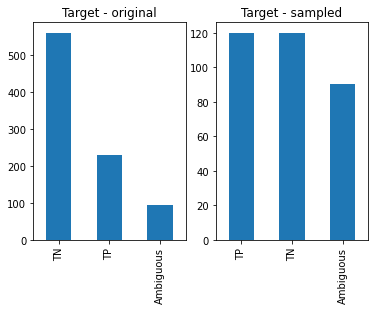

In [50]:
features = preprocessForSupervised(features, FFIEC_SEC_gt)

##### Supervised classification with Random Forest classifier

In [51]:
skf = StratifiedKFold(n_splits=10, random_state=100, shuffle=True)
clf = RandomForestClassifier(random_state=100)
params = {}
gs = GridSearchCV(clf, cv=skf, param_grid=params, scoring=['precision_macro', 'recall_macro', 'f1_macro'], refit='f1_macro')

Subset data in training set and test set

In [52]:
X_train, X_test, y_train, y_test = train_test_split(features.iloc[:,0:len(features.columns) - 1], features['TYPE'], test_size=0.25, random_state=100)

Train on trainining data

In [53]:
y_pred = clf.fit(X_train, y_train).predict(X_test)

Evaluate on test set

In [54]:
confusion_matrix(y_test, y_pred)

array([[17,  5,  4],
       [ 3, 20,  5],
       [ 9, 12,  8]], dtype=int64)

Some predicted match status examples:

In [55]:
examples = pd.DataFrame(y_test)
examples['PREDICTION'] = y_pred
print('Record classified as matches:')
examples_TP = examples[examples.PREDICTION == 1].head(10)
examples_TP

Record classified as matches:


,,TYPE,PREDICTION
FFIEC_ID,SEC_ID,,
2868352,1145956,1,1
3058114,1299582,1,1
463735,879089,2,1
2713920,1135986,1,1
972406,829937,2,1
480228,1102113,2,1
3547131,1537720,1,1
509811,1291629,1,1
930358,1506985,0,1


In [56]:
checkRecordPair(FFIEC, SEC, features, (930358,1506985))

(array([['united bankers bank', '1650 w 82nd st su 1500', 'bloomington',
         'MN', '55431', None]], dtype=object),
 array([['united bankers bancorporation', '1650 w 82nd st su 1500',
         'bloomington', 'MN', '55431', 'incorporated']], dtype=object),
                   Financial Institution Name Cleaned  \
 FFIEC_ID SEC_ID                                        
 930358   1506985                            0.913612   
 
                   Financial Institution Address  Financial Institution City  \
 FFIEC_ID SEC_ID                                                               
 930358   1506985                            1.0                         1.0   
 
                   Financial Institution Zip Code 5  \
 FFIEC_ID SEC_ID                                      
 930358   1506985                                 1   
 
                   Financial Institution State  TYPE  
 FFIEC_ID SEC_ID                                      
 930358   1506985                            1  

Since we have a very small amount of data a better evaluation is estimated with a stratified 10-fold cross validation

In [57]:
y_pred = gs.fit(features.iloc[:,0:len(features.columns) - 1], features['TYPE'])

In [58]:
gs.cv_results_

{'mean_fit_time': array([0.09101467]),
 'std_fit_time': array([0.00808395]),
 'mean_score_time': array([0.0081352]),
 'std_score_time': array([0.00022919]),
 'params': [{}],
 'split0_test_precision_macro': array([0.58333333]),
 'split1_test_precision_macro': array([0.41595442]),
 'split2_test_precision_macro': array([0.65201465]),
 'split3_test_precision_macro': array([0.65509259]),
 'split4_test_precision_macro': array([0.61805556]),
 'split5_test_precision_macro': array([0.68868169]),
 'split6_test_precision_macro': array([0.50980392]),
 'split7_test_precision_macro': array([0.59920635]),
 'split8_test_precision_macro': array([0.71428571]),
 'split9_test_precision_macro': array([0.48148148]),
 'mean_test_precision_macro': array([0.59179097]),
 'std_test_precision_macro': array([0.09091296]),
 'rank_test_precision_macro': array([1]),
 'split0_test_recall_macro': array([0.58333333]),
 'split1_test_recall_macro': array([0.52777778]),
 'split2_test_recall_macro': array([0.64814815]),
 's